# Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import norm, percentileofscore
from matplotlib.ticker import MultipleLocator

In [27]:
# prompt: Get data from this gsheet using pandas https://docs.google.com/spreadsheets/d/1QOGixwLrtKOayv0mA-VktSgHXhHAjkiCSFJUikPkxUo/export?format=csv

import pandas as pd

url = 'https://docs.google.com/spreadsheets/d/1QOGixwLrtKOayv0mA-VktSgHXhHAjkiCSFJUikPkxUo/export?format=csv'

# Load the data from the Google Sheet using pandas
df = pd.read_csv(url)
df = df[df['product'] != 'Bullets']

# Print the data
display(df)


,brand,product_type,product,RRP,gross_margin
0,SPOKE,Heroes,Basic Chinos,95.00,0.540611
1,Reiss,Heroes,Basic Chinos,88.00,0.540611
2,Gant,Heroes,Basic Chinos,100.00,0.540611
3,Ralph Lauren,Heroes,Basic Chinos,155.00,0.540611
4,Hackett,Heroes,Basic Chinos,135.00,0.540611
...,...,...,...,...,...
415,Oliver Sweeney,Trunks (3-pack),Trunks (3-pack),NaN,0.453414
416,Albam,Trunks (3-pack),Trunks (3-pack),NaN,0.453414
417,Luca Faloni,Trunks (3-pack),Trunks (3-pack),NaN,0.453414
418,Orlebar Brown,Trunks (3-pack),Trunks (3-pack),NaN,0.453414


# RRP vs Product

In [11]:

def plot_rrp_difference_with_std(df):
    # Process your data
    competitors = df[df['brand'] != 'SPOKE']
    avg_rrp = competitors.groupby('product')['RRP'].mean().reset_index()
    std_rrp = competitors.groupby('product')['RRP'].std().reset_index()

    # Merge the average and std data with SPOKE data
    spoke_rrp = df[df['brand'] == 'SPOKE'][['product', 'RRP']]
    merged_data = spoke_rrp.merge(avg_rrp, on='product', suffixes=('_spoke', '_avg')).merge(std_rrp, on='product')

    # Calculate the RRP difference
    merged_data['rrp_diff'] = merged_data['RRP_spoke'] - merged_data['RRP_avg']
    merged_data = merged_data.rename(columns={'RRP_spoke': 'RRP_spoke', 'RRP_avg': 'RRP_competitors_avg', 'RRP': 'RRP_std'})

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.bar(merged_data['product'], merged_data['rrp_diff'], capsize=5, color='skyblue', alpha=0.7)

    # Add error bars for standard deviation
    plt.errorbar(
        merged_data['product'],  # X values
        [0] * len(merged_data),  # Y values (centered at 0)
        yerr=merged_data['RRP_std'],  # Error values (±1σ)
        fmt='o',  # Marker style
        color='darkred',  # Color of error bars
        label='±1σ Competitors'
    )

    # Customize plot
    plt.xlabel('Product', fontsize=14)
    plt.ylabel('RRP Difference (SPOKE - Average Competitor)', fontsize=14)

    plt.title('RRP Difference Between SPOKE and Competitors with Standard Deviation', fontsize=16)
    plt.axhline(0, color='black', linestyle='-')
    plt.xticks(rotation=35, ha='center', fontsize=10)  # Rotate x-axis labels
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='-', alpha=0.5)  # Add horizontal gridlines
    plt.grid(axis='x', which='both', linestyle='', color='none') # Remove vertical gridlines
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.gca().yaxis.set_major_locator(MultipleLocator(10))

    # Show plot
    plt.show()

# STD vs Product

In [33]:
def plot_rrp_difference_in_std(df, label_type=None, show_margins=False):
    # Process your data
    competitors = df[df['brand'] != 'SPOKE']
    avg_rrp = competitors.groupby('product')['RRP'].mean().reset_index()
    std_rrp = competitors.groupby('product')['RRP'].std().reset_index()

    # Merge the average and std data with SPOKE data
    spoke_rrp = df[df['brand'] == 'SPOKE'][['product', 'RRP', 'gross_margin']]
    merged_data = spoke_rrp.merge(avg_rrp, on='product', suffixes=('_spoke', '_avg')).merge(std_rrp, on='product')

    # Calculate the RRP difference in £ and standard deviations
    merged_data['rrp_diff'] = merged_data['RRP_spoke'] - merged_data['RRP_avg']
    merged_data['rrp_diff_std'] = merged_data['rrp_diff'] / merged_data['RRP']

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    bars = ax1.bar(merged_data['product'], merged_data['rrp_diff_std'], color='skyblue', alpha=0.7)

    # Add labels based on label_type
    for index, bar in enumerate(bars):
        yval = bar.get_height()
        y_pos = yval + 0.05 if yval >= 0 else yval - 0.05
        if label_type == 'std':
            label = f'{yval:+.1f}σ'
        elif label_type == 'gbp':
            rrp_diff = merged_data.iloc[index]["rrp_diff"]
            label = f'{"+£" if rrp_diff >= 0 else "-£"}{abs(rrp_diff):.0f}'
        else:
            label = ''

        if label:
            ax1.text(bar.get_x() + bar.get_width() / 2, y_pos, label, ha='center', va='bottom' if yval >= 0 else 'top', fontsize=10)

    # Customize primary y-axis (STD Difference)
    ax1.set_xlabel('Product', fontsize=14)
    ax1.set_ylabel('RRP Difference in STDs (SPOKE - Average Competitor)', fontsize=14)
    ax1.set_title('RRP Difference Between SPOKE and Competitors in Terms of STDs', fontsize=16)
    ax1.axhline(0, color='black', linestyle='-')
    ax1.set_xticks(range(len(merged_data['product'])))
    ax1.set_xticklabels(merged_data['product'], rotation=35, ha='center', fontsize=10)
    ax1.yaxis.set_major_locator(MultipleLocator(1))
    ax1.set_ylim(-3, 3)  # Set y-axis limits from -3σ to +3σ
    ax1.grid(axis='y', linestyle='-', alpha=0.5)
    ax1.grid(axis='x', which='both', linestyle='', color='none')

    # Plot secondary y-axis (Gross Margin) if show_margins is True
    if show_margins:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Gross Margin', fontsize=14, color='darkred')
        ax2.plot(merged_data['product'], merged_data['gross_margin'], color='darkred', marker='o')
        ax2.tick_params(axis='y', labelcolor='darkred')
        ax2.set_ylim(0.2, 0.8)

    # Show plot
    plt.tight_layout()
    plt.show()

# Percentile (Normal Dist)

In [17]:
def calculate_normal_distribution_percentile(df):
    competitors = df[df['brand'] != 'SPOKE']
    avg_rrp = competitors.groupby('product')['RRP'].mean().reset_index()
    std_rrp = competitors.groupby('product')['RRP'].std().reset_index()

    spoke_rrp = df[df['brand'] == 'SPOKE'][['product', 'RRP', 'gross_margin']]
    merged_data = spoke_rrp.merge(avg_rrp, on='product', suffixes=('_spoke', '_avg')).merge(std_rrp, on='product')

    merged_data['z_score'] = (merged_data['RRP_spoke'] - merged_data['RRP_avg']) / merged_data['RRP']
    merged_data['percentile_normal'] = norm.cdf(merged_data['z_score']) * 100

    fig, ax1 = plt.subplots(figsize=(14, 7))

    bars = ax1.bar(merged_data['product'], merged_data['percentile_normal'], color='skyblue', alpha=0.7)

    # Customize primary y-axis (Percentile)
    ax1.set_xlabel('Product', fontsize=14)
    ax1.set_ylabel('Percentile (Normal Distribution)', fontsize=14)
    ax1.set_title('Percentile of SPOKE Products Assuming Normal Distribution', fontsize=16)
    ax1.set_xticks(range(len(merged_data['product'])))
    ax1.set_xticklabels(merged_data['product'], rotation=35, ha='center', fontsize=10)
    ax1.set_yticks(np.arange(0, 101, 10))
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.grid(axis='x', which='both', linestyle='', color='none')
    ax1.axhline(50, color='darkred', linewidth=1.5, linestyle='-')  # Base axis at 50

    # Adding value labels on top of the bars with percentage sign
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{round(yval, 1)}%', ha='center', va='bottom', fontsize=10)

    # Plot secondary y-axis (Gross Margin)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Gross Margin', fontsize=14, color='darkred')
    ax2.plot(merged_data['product'], merged_data['gross_margin'], color='darkred', marker='o')
    ax2.tick_params(axis='y', labelcolor='darkred')

    plt.tight_layout()
    plt.show()

# Percentile (Rank)

In [7]:
def calculate_rank_based_percentile(df):
    competitors = df[df['brand'] != 'SPOKE']
    merged_data = df[df['brand'] == 'SPOKE'][['product', 'RRP']]

    def calculate_percentile(row):
        product = row['product']
        competitor_prices = competitors[competitors['product'] == product]['RRP'].dropna()
        if len(competitor_prices) == 0:
            return np.nan  # or handle as appropriate
        rank = np.sum(competitor_prices <= row['RRP'])
        percentile = (rank / len(competitor_prices)) * 100
        return percentile

    merged_data['percentile_rank'] = merged_data.apply(calculate_percentile, axis=1)

    # Drop products with no competitors (if necessary)
    merged_data = merged_data.dropna(subset=['percentile_rank'])

    plt.figure(figsize=(14, 7))
    bars = plt.bar(merged_data['product'], merged_data['percentile_rank'], color='green', alpha=0.7)

    plt.xlabel('Product', fontsize=14)
    plt.ylabel('Percentile (Rank-Based)', fontsize=14)
    plt.title('Percentile of SPOKE Products Based on Rank', fontsize=16)
    plt.xticks(rotation=35, ha='center', fontsize=10)
    plt.yticks(np.arange(0, 101, 10), fontsize=12)  # Adjust y-axis ticks for better visualization
    plt.axhline(50, color='darkred', linewidth=1.5, linestyle='-')  # Base axis at 50
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='', alpha=0.7)

    # Adding value labels on top of the bars with percentage sign
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{round(yval, 1)}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


# Product RRP vs Competitor

In [8]:

def plot_rrp_comparison(df, product, y_increments=10, add_rrp_labels=False):
    # Filter data for the specified product
    product_data = df[df['product'] == product]

    # Compute the average RRP for the product
    mean_rrp = product_data['RRP'].mean()

    # Calculate the range of RRP values to determine a suitable offset for labels
    rrp_range = product_data['RRP'].max() - product_data['RRP'].min()
    label_offset = rrp_range * 0.02  # 2% of the range as an offset

    # Plotting
    plt.figure(figsize=(13, 7))

    # Plot competitors' RRPs
    competitors_data = product_data[product_data['brand'] != 'SPOKE']
    plt.scatter(competitors_data['brand'], competitors_data['RRP'], label='Competitors', color='blue', s=100, alpha=0.6)

    # Plot SPOKE's RRP
    spoke_data = product_data[product_data['brand'] == 'SPOKE']
    plt.scatter(spoke_data['brand'], spoke_data['RRP'], color='red', s=50)
    plt.scatter(spoke_data['brand'], spoke_data['RRP'], color='red', marker='x', s=200)

    # Adding labels above the point
    label_size = 10
    for idx in competitors_data.index:
        plt.text(competitors_data.loc[idx, 'brand'], competitors_data.loc[idx, 'RRP'] + label_offset,
                competitors_data.loc[idx, 'brand'], fontsize=label_size, ha='center', rotation=0)

    for idx in spoke_data.index:
        plt.text(spoke_data.loc[idx, 'brand'], spoke_data.loc[idx, 'RRP'] + label_offset,
                spoke_data.loc[idx, 'brand'], fontsize=label_size, ha='center', color='red', rotation=0)

    # Adding RRP labels just below each data point with GBP currency symbol
    if add_rrp_labels:
        for idx in competitors_data.index:
            plt.text(competitors_data.loc[idx, 'brand'], competitors_data.loc[idx, 'RRP'] - label_offset,
                    f"£{competitors_data.loc[idx, 'RRP']:.2f}", fontsize=label_size, ha='center', va='top')

        for idx in spoke_data.index:
            plt.text(spoke_data.loc[idx, 'brand'], spoke_data.loc[idx, 'RRP'] - label_offset,
                    f"£{spoke_data.loc[idx, 'RRP']:.2f}", fontsize=label_size, ha='center', va='top', color='red')

    # Add horizontal line for average RRP
    plt.axhline(mean_rrp, color='darkred', linestyle='-', label=f'Mean RRP: £{mean_rrp:.2f}')

    # Customize plot
    plt.xticks([])
    plt.grid(axis='y', linestyle='-', color='grey', alpha=0.2)
    plt.grid(axis='x', which='both', linestyle='', color='none') # Remove vertical gridlines
    plt.ylabel('RRP', fontsize=14)
    plt.title(f'{product}', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_increments)) # set y axis increments to 10

    plt.show()

# Visualisations

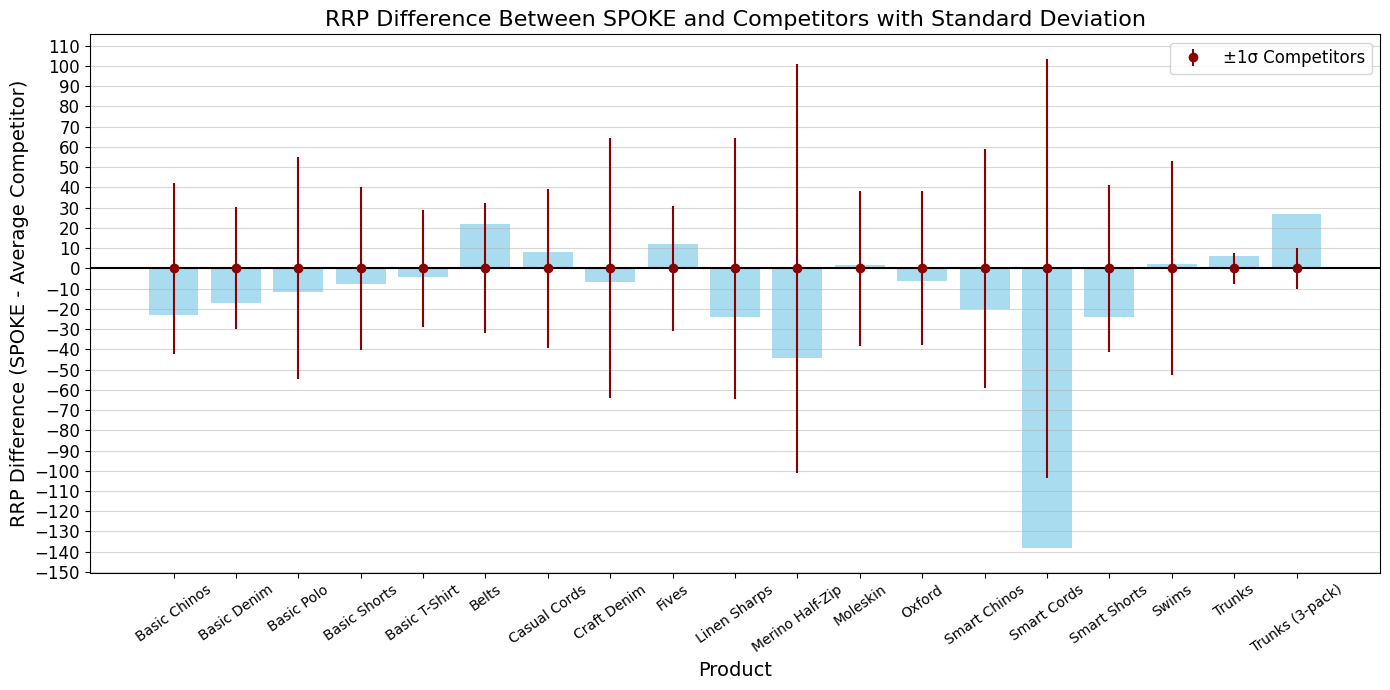

In [21]:
plot_rrp_difference_with_std(df)

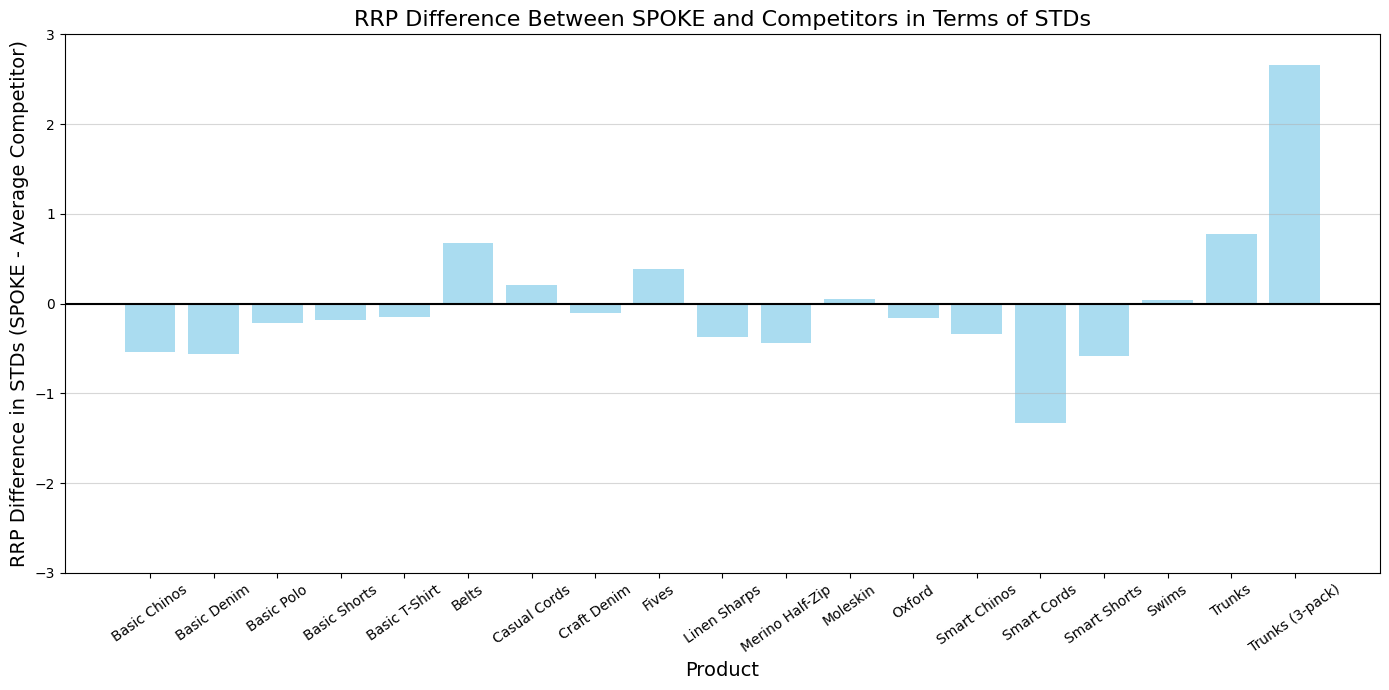

In [34]:
plot_rrp_difference_in_std(df, label_type=None, show_margins=False)

In [35]:
def export_rrp_difference_to_excel(df, file_name='rrp_difference.xlsx'):
    # Process your data
    competitors = df[df['brand'] != 'SPOKE']
    avg_rrp = competitors.groupby('product')['RRP'].mean().reset_index()
    std_rrp = competitors.groupby('product')['RRP'].std().reset_index()

    # Merge the average and std data with SPOKE data
    spoke_rrp = df[df['brand'] == 'SPOKE'][['product', 'RRP', 'gross_margin']]
    merged_data = spoke_rrp.merge(avg_rrp, on='product', suffixes=('_spoke', '_avg')).merge(std_rrp, on='product')

    # Calculate the RRP difference in £ and standard deviations
    merged_data['rrp_diff'] = merged_data['RRP_spoke'] - merged_data['RRP_avg']
    merged_data['rrp_diff_std'] = merged_data['rrp_diff'] / merged_data['RRP']

    # Select the relevant columns to export
    export_data = merged_data[['product', 'rrp_diff', 'rrp_diff_std', 'gross_margin']]

    # Export the data to Excel
    export_data.to_excel(file_name, index=False)

# Example usage
# df = your_dataframe_here
export_rrp_difference_to_excel(df)

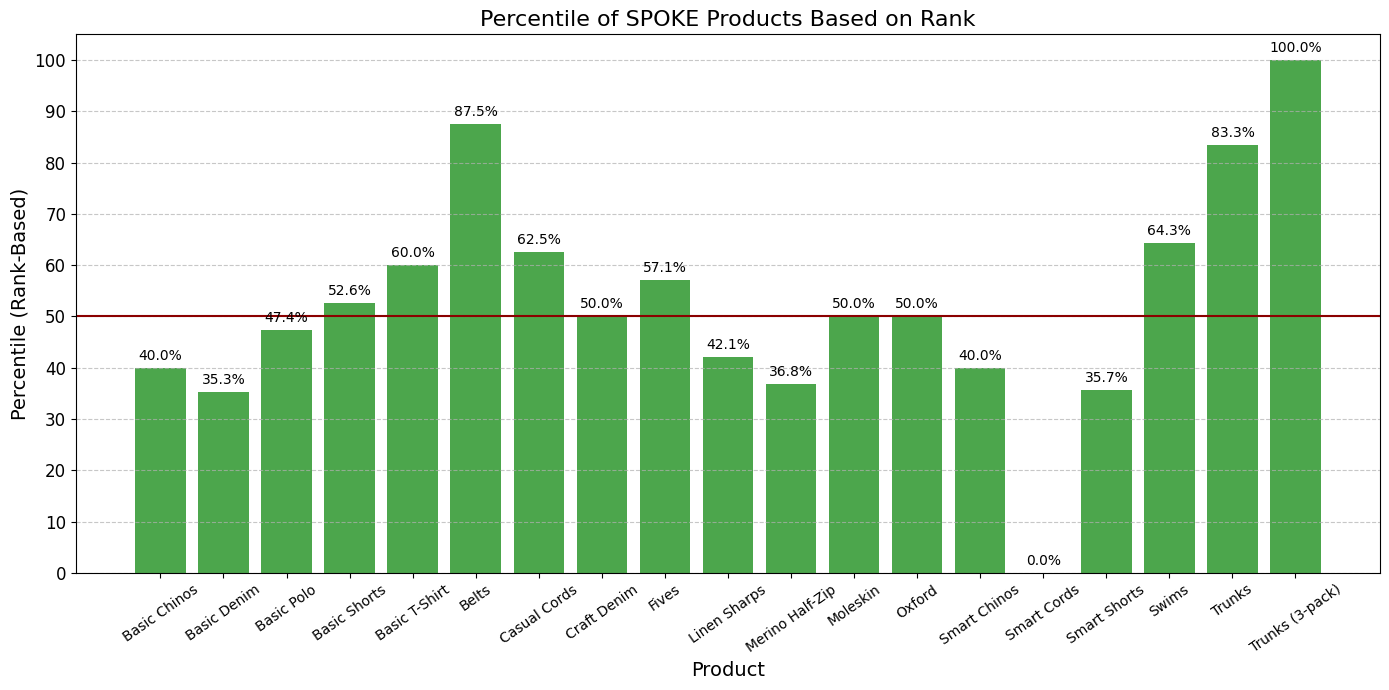

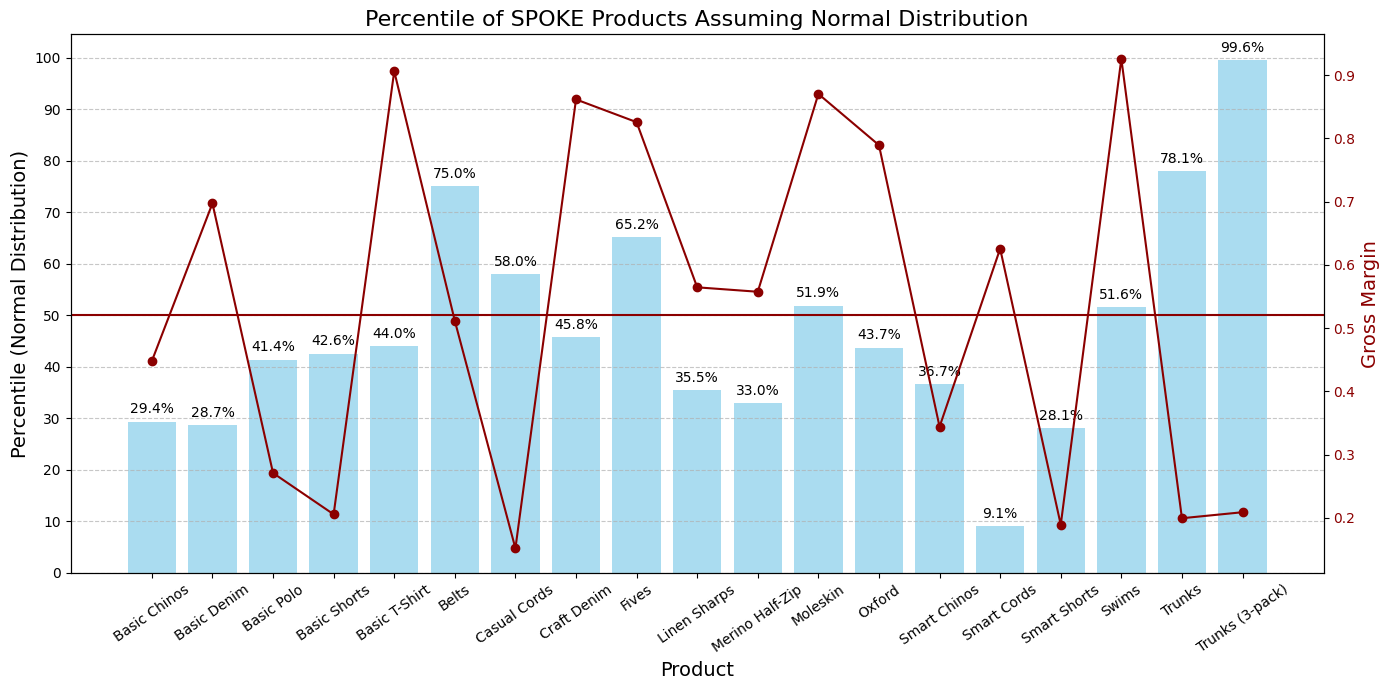

In [18]:
calculate_rank_based_percentile(df)
calculate_normal_distribution_percentile(df)

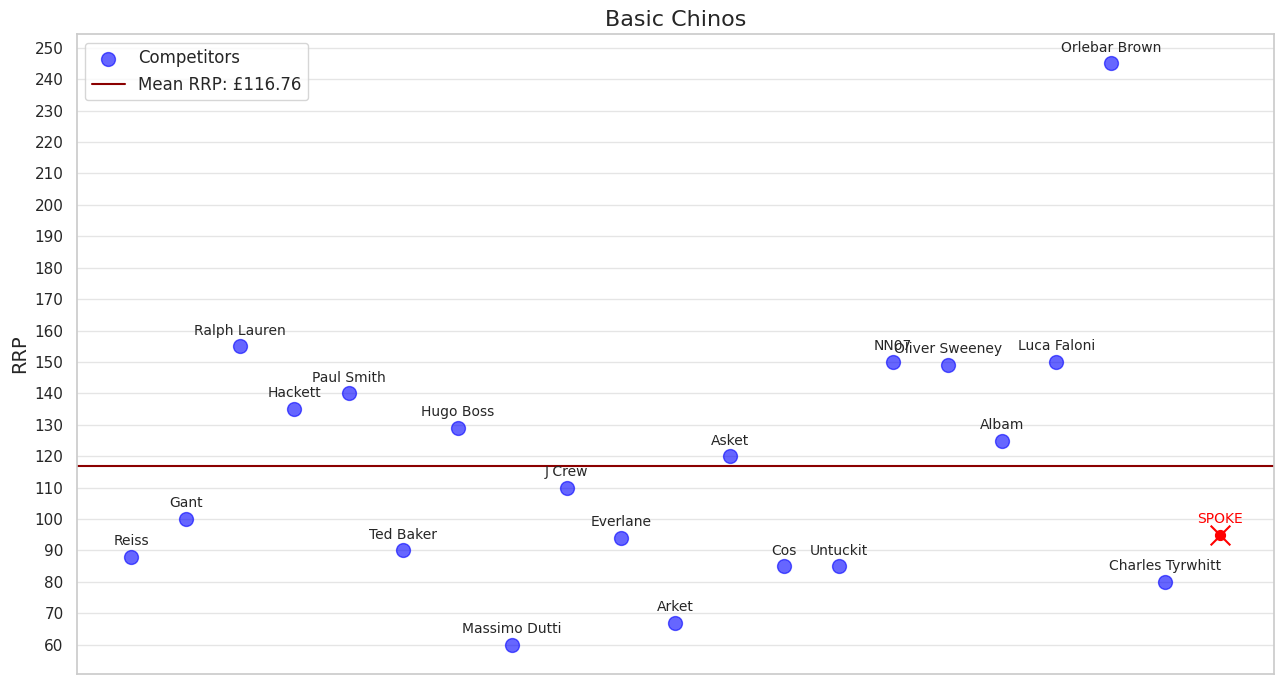

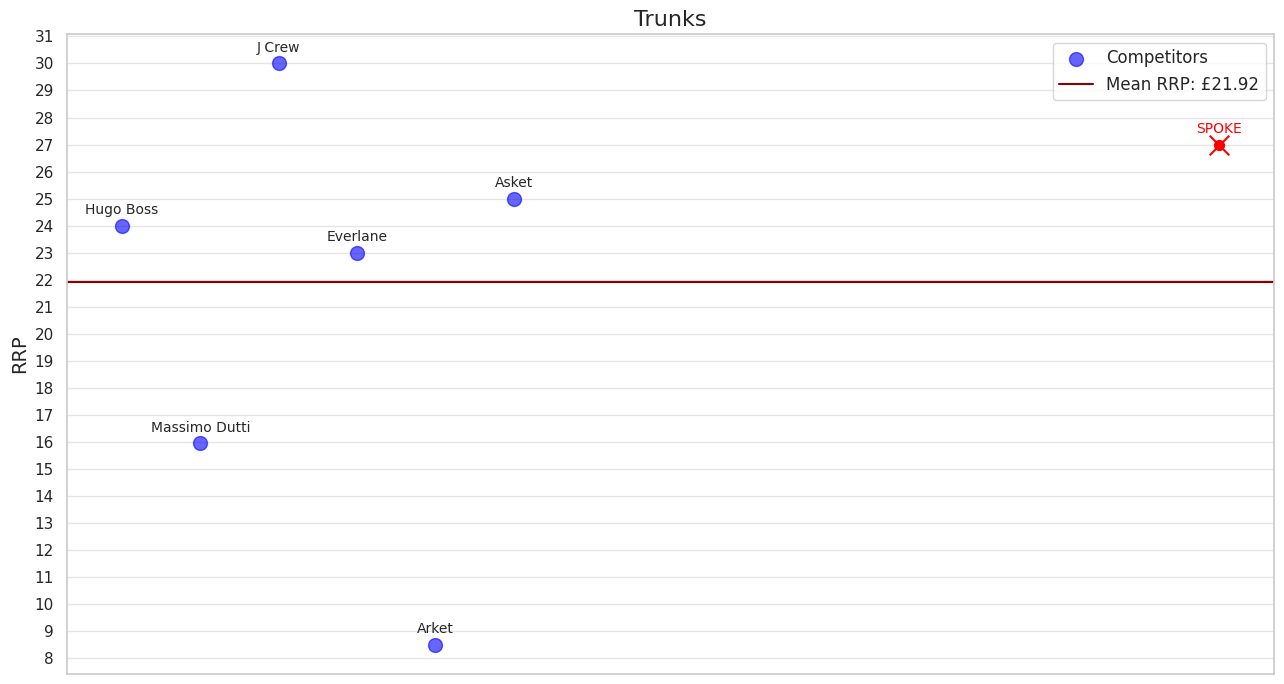

In [ ]:
plot_rrp_comparison(df, 'Basic Chinos', y_increments=10, add_rrp_labels=False)
plot_rrp_comparison(df, 'Trunks', y_increments=1, add_rrp_labels=False)